In [1]:
# !pip install pytorch-ignite
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

In [2]:
import torch
import torch.nn.functional as F
from torch import nn

from torch.utils.data.dataloader import default_collate

import matplotlib.pyplot as plt
import os

import numpy as np

from src.datasets.datasets import MovielensDataset
from src.models.mlstm import mLSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import datetime

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")

find_lr = False

ablation_types = ['movie_network', 'genre', 'user_history', 'user_ratings', 'user_info', 'title']
ablation = None
rnn_type = 'lstm'

# model

In [3]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [4]:
PADDING_IDX = 0
class mLSTMNet(nn.Module):
    """
    Module representing users through running a recurrent neural network
    over the sequence, using the hidden state at each timestep as the
    sequence representation, a'la [2]_
    During training, representations for all timesteps of the sequence are
    computed in one go. Loss functions using the outputs will therefore
    be aggregating both across the minibatch and across time in the sequence.
    Parameters
    ----------
    num_items: int
        Number of items to be represented.
    embedding_dim: int, optional
        Embedding dimension of the embedding layer, and the number of hidden
        units in the LSTM layer.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    References
    ----------
    .. [2] Hidasi, Balazs, et al. "Session-based recommendations with
       recurrent neural networks." arXiv preprint arXiv:1511.06939 (2015).
    """

    def __init__(self, num_items, embedding_dim=32, sparse=False, rnn_type='mlstm', ablation=None):

        super(mLSTMNet, self).__init__()

        self.embedding_dim = embedding_dim

        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                padding_idx=PADDING_IDX,
                                                sparse=sparse)

        self.ablation = ablation
        self.rnn_type = rnn_type
        title_dim = 0
        ubranch_dim = 0
        user_history_dim = 0
        movie_dim = 0
        
            

            
            
        if ablation != 'movie_network':
            movie_dim = movie_dim + embedding_dim
        if ablation != 'genre':
            movie_dim = movie_dim + 18
        
        if movie_dim > 0:
            self.mbranch = nn.Sequential(
                nn.Linear(movie_dim, movie_dim),
                nn.ReLU(movie_dim),
                nn.Dropout(0.5),
                
                nn.Linear(movie_dim, movie_dim),
                nn.ReLU(movie_dim),
                nn.Dropout(0.5),
                
                nn.Linear(movie_dim, movie_dim),
                nn.ReLU(movie_dim),
            )
        
        if ablation != 'title':
            title_input_dim = 384
            title_dim = title_input_dim // 2
            self.tbranch = nn.Sequential(                
                nn.Linear(title_input_dim, title_dim),
                nn.ReLU(title_dim),
            )

            
        if ablation != 'user_info':
            ubranch_dim = 21 + 1 + 2 
            self.ubranch = nn.Sequential(
                nn.Linear(ubranch_dim, ubranch_dim),
                nn.ReLU(ubranch_dim),
                nn.Dropout(0.5),
                
                nn.Linear(ubranch_dim, ubranch_dim),
                nn.ReLU(ubranch_dim),
                nn.Dropout(0.5),
                
                nn.Linear(ubranch_dim, ubranch_dim),
                nn.ReLU(ubranch_dim),
            )
            
        
        if ablation != 'user_history':
            
            if ablation != 'user_ratings':
                user_history_dim = embedding_dim+1
            else:
                user_history_dim = embedding_dim
                
            h_init = torch.zeros(user_history_dim)
            h_init.normal_(0, 1.0 / self.embedding_dim)
            self.h_init = nn.Parameter(h_init, requires_grad=True)
            if self.rnn_type == 'mlstm':

                self.mlstm = mLSTM(input_size=user_history_dim,
                                   hidden_size=user_history_dim)
            else:
                self.lstm = nn.LSTM(
                    input_size=user_history_dim,
                    hidden_size=user_history_dim,
                    batch_first=True
                )

            
        self.user_history_dim = user_history_dim
            

        ## THIS IS IRRELEVANT - just for making an ratings output
        ################################################################################################
        concat_dim = user_history_dim+ubranch_dim+movie_dim+title_dim
        self.rating  = nn.Sequential(
            # nn.Dropout(0.5),
            # nn.Linear(user_history_dim+ubranch_dim+movie_dim+title_dim, embedding_dim),
            # nn.ReLU(embedding_dim),
            # nn.Dropout(0.5),
            # nn.Linear(embedding_dim, 1)
            
            
            
            nn.Dropout(0.5),
            
            nn.Linear(concat_dim, concat_dim // 2),
            nn.ReLU(concat_dim // 2),
            nn.Dropout(0.5),
            
            nn.Linear(concat_dim // 2, concat_dim // 2),
            nn.ReLU(concat_dim // 2),
            nn.Dropout(0.5),
            
            
            nn.Linear(concat_dim // 2, 1)
        )
        
    
    def ablate(self, ablation_eval=()):
        if 'movie' in ablation_eval:
            self.mbranch.requires_grad_(False)
            self.mbranch.apply(self._ablate_weights)
        
        if 'title' in ablation_eval:
            self.tbranch.requires_grad_(False)
            self.tbranch.apply(self._ablate_weights)
        
        if 'user_info' in ablation_eval:
            self.ubranch.requires_grad_(False)
            self.ubranch.apply(self._ablate_weights)
            
        if 'user_history' in ablation_eval:
            if self.rnn_type == 'mlstm':
                self.mlstm.requires_grad_(False)
                self.mlstm.lstm_cell.weight_ih.data.fill_(0.0)
                self.mlstm.lstm_cell.weight_hh.data.fill_(0.0)
                
                self.mlstm.lstm_cell.bias_ih.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
                self.mlstm.lstm_cell.bias_hh.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
                

            elif self.rnn_type =='lstm':
                self.lstm.requires_grad_(False)
                self.lstm.weight_ih_l0.data.fill_(0.0)
                self.lstm.weight_hh_l0.data.fill_(0.0)
                
                self.lstm.bias_ih_l0.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
                self.lstm.bias_hh_l0.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
        
    def _ablate_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data.fill_(0.0)
            
    def forward(self, item_sequences=None, ratings_sequences=None, lengths=None, movies=None, user_info=None, mgenre=None, mtitle=None):
        """
        Compute user representation from a given sequence.
        Returns
        -------
        tuple (all_representations, final_representation)
            The first element contains all representations from step
            -1 (no items seen) to t - 1 (all but the last items seen).
            The second element contains the final representation
            at step t (all items seen). This final state can be used
            for prediction or evaluation.
        """
        

        if self.ablation != 'movie_network':
            movie_embedding = (self.item_embeddings(torch.unsqueeze(movies, 0)).squeeze(0))
            if self.ablation != 'genre':
                mov_emb = torch.cat((movie_embedding, mgenre), dim=1)
            else:            
                mov_emb = movie_embedding


        elif self.ablation != 'genre':
            mov_emb = mgenre

            
        mov_emb = self.mbranch(mov_emb)
        
        # if 'movie' in ablation_eval:
        #     mov_emb = torch.zeros_like(mov_emb)
        

        if self.ablation != 'title':
            tit_emb = self.tbranch(mtitle)
            
            # if 'title' in ablation_eval:
            #     tit_emb = torch.zeros_like(tit_emb)

                
            

        if self.ablation != 'user_info':
            user_emb = self.ubranch(user_info)
            # if 'user_info' in ablation_eval:
            #     user_emb = torch.zeros_like(user_emb)
                
        if self.ablation != 'user_history':
            # Make the embedding dimension the channel dimension
            sequence_embeddings = self.item_embeddings(item_sequences)
            batch_size, seq_len, _ = sequence_embeddings.size()
            embedding_dim = self.h_init.size()[0]
            seq_start = self.h_init.expand(batch_size, embedding_dim)
            # pad from left with initial state
            if self.ablation != 'user_ratings':
                ratings_embedding = (ratings_sequences.unsqueeze(2) -  3)/(1.155*self.embedding_dim)

                X= torch.cat([sequence_embeddings, ratings_embedding], dim=2)
            else:
                X=sequence_embeddings

            if self.rnn_type == 'mlstm':
                X = self.mlstm(X, (seq_start, seq_start))
                user_representations = X.permute(0, 2, 1)[:, :, -1]
            else:
                seq_start = seq_start.unsqueeze(0)

                X = torch.nn.utils.rnn.pack_padded_sequence(X, lengths,enforce_sorted=False, batch_first=True)                
                X, _ = self.lstm(X, (seq_start, seq_start))
                X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

                # X = X.contiguous()
                user_representations =  X.permute(0, 2, 1)[:, :, -1] #.view(-1, X.shape[2])
                
            # if 'user_history' in ablation_eval:
            #     user_representations = torch.zeros_like(user_representations)
                


        ## user_representations[:, :, -1] is your user history representation (lstm output - )
        ## make modifications after this point
        ###################################################################################

        # print(movie_embedding.shape, user_representations.shape)
        
        if self.ablation == 'user_info':
            x = torch.cat([user_representations, mov_emb, tit_emb], dim=1)
        elif self.ablation == 'user_history':
            x = torch.cat([user_emb, mov_emb, tit_emb], dim=1)
        elif self.ablation == 'title':
            # for k in [user_representations, user_emb, mov_emb, genr_emb]:
            #     print(k.size())
            x = torch.cat([user_representations, user_emb, mov_emb], dim=1)
        else:
            x = torch.cat([user_representations, user_emb, mov_emb, tit_emb], dim=1)
        return self.rating(x).squeeze(1)


# Run

In [5]:
common_space = {
    'batch_size': 512,
    'learn_rate': 5e-04,
    'l2': 1e-04,
    'n_iter': 20,
    'embedding_dim': 110,
}

space = common_space

batch_size = int(space['batch_size'])
learn_rate = space['learn_rate']
n_iter = int(space['n_iter'])
embedding_dim = int(space['embedding_dim'])
l2 = space['l2']

early_stop_crit = 5
min_epochs = n_iter*0.3+early_stop_crit

In [6]:
save_dir = os.path.join('data','ml-1m-split')
results_folder = os.path.join('results',f'{rnn_type}_ablation-title',f'{ablation}Ablation', 'ml-1m-split', script_start_time)
model_folder = os.path.join('model',f'{rnn_type}_ablation-title',f'{ablation}Ablation', 'ml-1m-split', script_start_time)



# save_dir = os.path.join('/content/drive/MyDrive/ECSE552proj',save_dir)
# results_folder = os.path.join('/content/drive/MyDrive/ECSE552proj',results_folder)
# model_folder = os.path.join('/content/drive/MyDrive/ECSE552proj',model_folder)



if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

load_bools = (ablation != 'user_history', # user_history
              ablation != 'user_info', # user_info
              ablation != 'movie_info', # movie_info
              rnn_type == 'lstm', # lengths
              'post' if rnn_type == 'lstm' else 'pre', #pad
              # None,
              100 if rnn_type == 'mlstm' else 0, # max_history_length
             ) 
train = MovielensDataset(os.path.join(save_dir,'users_train_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), *load_bools)
val = MovielensDataset(os.path.join(save_dir,'users_val_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), *load_bools)
test = MovielensDataset(os.path.join(save_dir,'users_test_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), *load_bools)

model/lstm_ablation-title/NoneAblation/ml-1m-split/2022-04-14_10h02m51


In [7]:
def pad_collate(batch, key):
    
    padding_value = 0 if key == 'user_history_movie_id' else 3
    if rnn_type == 'lstm':
        return torch.nn.utils.rnn.pad_sequence([torch.as_tensor(x) for x in batch], batch_first=True, padding_value=padding_value)
    else:
        pad_to = max([len(x) for x in batch])
        
        return torch.vstack([F.pad(torch.as_tensor(x), (pad_to - len(x), 0), 'constant', constant=padding_value) for x in batch])
    

def collate(batch):
    elem = batch[0]
    elem_type = type(elem)
    # print([key for key in elem])
    d = {key: (pad_collate([d[key] for d in batch], key) if (key == 'user_history_movie_id' or key == 'user_history_rating')
               else default_collate([d[key] for d in batch]))
         for key in elem}
    try:
        return elem_type(d)
    except TypeError:
        # The mapping type may not support `__init__(iterable)`.
        return d

In [8]:
# dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, collate_fn=collate)
# dataloader_test = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate)
# dataloader_val = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate)

dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [9]:
# for _, sample in enumerate(dataloader_train):
#     one_samp = sample
#     break

In [10]:
# one_samp

In [11]:
print("device is {}!".format(device))

num_items = train.movies_genres_df.index.max()+1


device is cuda!


In [12]:
if find_lr:
    from ignite.handlers import FastaiLRFinder
    from ignite.engine.engine import Engine

    criterion = torch.nn.MSELoss()
    def train_step(engine, sample):
        model.train()
        optimizer.zero_grad()   

        if ablation != 'user_history':
            user_history_movie_id = sample['user_history_movie_id'].to(device)
            if ablation != 'user_ratings':
                user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
            else:
                user_history_rating = None
        else:
            user_history_movie_id = None
            user_history_rating = None

        movie_id = sample['movie_id'].to(device)
        rating = sample['rating'].to(device)

        if ablation != 'genre':
            mgenre = sample['movie_info_genres'].to(device)
        else:
            mgenre = None

        if ablation != 'user_info':
            user_info = sample['user_info'].to(device)
        else:
            user_info = None

        if ablation != 'title':
            mtitle = sample['movie_info_title'].to(device)
        else:
            mtitle = None
            
        if rnn_type == 'lstm':
            lengths = sample['user_history_len_cut'].cpu()
        else:
            lengths = None

        # with torch.cuda.amp.autocast():
        #     pred = model(user_history_movie_id, movie_id)

        #     loss = criterion(pred, rating.to(torch.float16))

        pred = model(item_sequences=user_history_movie_id,
                      ratings_sequences=user_history_rating,
                      lengths=lengths,
                      movies=movie_id,
                      user_info=user_info,
                      mgenre=mgenre,
                      mtitle=mtitle,
                    ablation_eval=())

        loss = torch.sqrt(criterion(pred, rating.to(torch.float32)))


        loss.backward()
        optimizer.step()

        return loss.item()

    trainer = Engine(train_step)


    model = mLSTMNet(
        num_items,
        embedding_dim=embedding_dim,
        rnn_type=rnn_type,
        ablation=ablation)

    model.to(device)
    optimizer = torch.optim.AdamW(
                    model.parameters(),
                    weight_decay=l2,
                    lr=1e-06,
                    betas=(0.9, 0.99),
                    eps = 1e-05,
                )



    lr_finder = FastaiLRFinder()
    to_save = {"model": model, "optimizer": optimizer}

    with lr_finder.attach(trainer, to_save=to_save, diverge_th=5.0, end_lr=20) as trainer_with_lr_finder:
        trainer_with_lr_finder.run(dataloader_train)

    # Get lr_finder results
    lr_finder.get_results()
    plt.savefig(os.path.join(results_folder, 'lr_finder.png'))

    # Plot lr_finder results (requires matplotlib)
    lr_finder.plot()

    # get lr_finder suggestion for lr
    learn_rate = lr_finder.lr_suggestion()
    print(learn_rate)
    with open(os.path.join(results_folder, 'lr_finder.txt'), 'a') as the_file:
        the_file.write(str(learn_rate))



In [14]:

criterion = torch.nn.MSELoss()
model = mLSTMNet(
    num_items,
    embedding_dim=embedding_dim,
    rnn_type=rnn_type,
    ablation=ablation)

model.to(device)
optimizer = torch.optim.AdamW(
                model.parameters(),
                weight_decay=l2,
                lr=learn_rate,
                        betas=(0.9, 0.99),
                    eps = 1e-05,
            )


scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learn_rate, pct_start=0.05, div_factor=2, final_div_factor=1, epochs=n_iter, steps_per_epoch=len(dataloader_train))

scaler = torch.cuda.amp.GradScaler()

In [15]:
def compute_acc(dataloader, model):
    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, sample in enumerate(dataloader):
            if ablation != 'user_history':
                user_history_movie_id = sample['user_history_movie_id'].to(device)
                if ablation != 'user_ratings':
                    user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
                else:
                    user_history_rating = None
            else:
                user_history_movie_id = None
                user_history_rating = None

            movie_id = sample['movie_id'].to(device)
            rating = sample['rating'].to(device)

            if ablation != 'genre':
                mgenre = sample['movie_info_genres'].to(device)
            else:
                mgenre = None

            if ablation != 'user_info':
                user_info = sample['user_info'].to(device)
            else:
                user_info = None

            if ablation != 'title':
                mtitle = sample['movie_info_title'].to(device)
            else:
                mtitle = None
                
            if rnn_type == 'lstm':
                lengths = sample['user_history_len_cut'].cpu()
            else:
                lengths = None

            # with torch.cuda.amp.autocast():
            #     pred = model(user_history_movie_id, movie_id)

            #     loss = criterion(pred, rating.to(torch.float16))

            pred = model(item_sequences=user_history_movie_id,
                         ratings_sequences=user_history_rating,
                         lengths=lengths,
                         movies=movie_id,
                         user_info=user_info,
                         mgenre=mgenre,
                         mtitle=mtitle,)
            pred_rounded = torch.clamp(pred,1,5).round()



            loss = criterion(pred, rating.to(torch.float32))
            accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
            loss_running.append(loss.item())
            accu_running.append(accu.item())

            # we will weight average by batch size later
            mean_weights.append(len(movie_id))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights), np.average(accu_running, weights=mean_weights)
       

In [16]:
from tqdm.autonotebook import tqdm

# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

accu_history = []
accu_history_val = []

loss_history_running = []
accu_history_running = []
lr_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start train...")
outer = tqdm(total=n_iter, desc='Epochs', position=0)
inner = tqdm(total=len(dataloader_train), desc=f'Batch', position=1)
for epoch in range(n_iter):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epoch > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'checkpt_earlystop_{epoch}.pth'))
        break
    
    early_stop_count += 1
    
    #Train mode
    model.train()
    loss_running = []
    accu_running = []
    mean_weights = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, sample in enumerate(dataloader_train):
        lr_history_running.append(scheduler.get_last_lr())
        
        
        optimizer.zero_grad()
        if ablation != 'user_history':
            user_history_movie_id = sample['user_history_movie_id'].to(device)
            if ablation != 'user_ratings':
                user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
            else:
                user_history_rating = None
        else:
            user_history_movie_id = None
            user_history_rating = None

        movie_id = sample['movie_id'].to(device)
        rating = sample['rating'].to(device)

        if ablation != 'genre':
            mgenre = sample['movie_info_genres'].to(device)
        else:
            mgenre = None

        if ablation != 'user_info':
            user_info = sample['user_info'].to(device)
        else:
            user_info = None

        if ablation != 'title':
            mtitle = sample['movie_info_title'].to(device)
        else:
            mtitle = None

        if rnn_type == 'lstm':
            lengths = sample['user_history_len_cut'].cpu()
        else:
            lengths = None

        # with torch.cuda.amp.autocast():
        #     pred = model(user_history_movie_id, movie_id)

        #     loss = criterion(pred, rating.to(torch.float16))

        pred = model(item_sequences=user_history_movie_id,
                     ratings_sequences=user_history_rating,
                     lengths=lengths,
                     movies=movie_id,
                     user_info=user_info,
                     mgenre=mgenre,
                     mtitle=mtitle,)
        
        loss = criterion(pred, rating.to(torch.float32))
        loss_running.append(loss.item())

        pred_rounded = torch.clamp(pred,1,5).round()
        accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
        accu_running.append(accu.item())

        # we will weight average by batch size later
        mean_weights.append(len(movie_id))


        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        optimizer.step()
            # Change the learning rate
        scheduler.step()
        
        inner.update(1)
        
    loss_history.append(np.average(loss_running, weights=mean_weights))
    accu_history.append(np.average(accu_running, weights=mean_weights))
    
    loss_history_running.append(loss_running)
    accu_history_running.append(loss_running)



    # Evaluate mode
    model.eval()
    with torch.no_grad():    
        curr_loss_val, curr_accu_val = compute_acc(dataloader_val, model)
        loss_history_val.append(curr_loss_val)
        accu_history_val.append(curr_accu_val)
    


    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'best_model.pth'))
        early_stop_count = 0
    
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= n_iter-1:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'checkpt{epoch}.pth'))
        
    # Print the results    
    outer.update(1)
    print("epoch:", epoch, \
          "train loss:", round(loss_history[-1], 6), \
          "validation loss:", round(loss_history_val[-1], 6), \
            "train accuracy:", round(accu_history[-1], 6), \
          "validation accuracy:", round(accu_history_val[-1], 6),
         "next_lr:", scheduler.get_last_lr())


# Save final model 
checkpoint = { 
    'epoch': epoch,
    'model': model,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'scaler': scaler}
torch.save(checkpoint, os.path.join(model_folder, f'final_model.pth'))

Start train...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.910454 validation loss: 1.042489 train accuracy: 0.304994 validation accuracy: 0.351881 next_lr: [0.0004999999973099775]
epoch: 1 train loss: 1.169194 validation loss: 1.026 train accuracy: 0.346296 validation accuracy: 0.361857 next_lr: [0.0004982908918876707]
epoch: 2 train loss: 1.114639 validation loss: 1.017308 train accuracy: 0.355005 validation accuracy: 0.366483 next_lr: [0.0004932187323300366]
epoch: 3 train loss: 1.081027 validation loss: 1.010081 train accuracy: 0.360389 validation accuracy: 0.377203 next_lr: [0.00048492187392767407]
epoch: 4 train loss: 1.059357 validation loss: 1.007622 train accuracy: 0.364791 validation accuracy: 0.379966 next_lr: [0.00047362663334950413]
epoch: 5 train loss: 1.048519 validation loss: 1.008626 train accuracy: 0.366694 validation accuracy: 0.376414 next_lr: [0.0004596411153140045]
epoch: 6 train loss: 1.036041 validation loss: 1.049507 train accuracy: 0.368265 validation accuracy: 0.376326 next_lr: [0.00044334680829

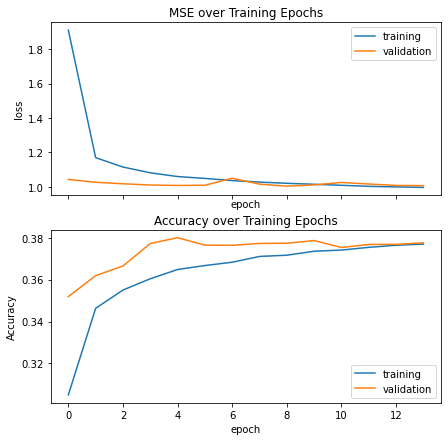

In [17]:
# Print loss history
fig, axs = plt.subplots(2, 1, figsize=(7, 7), squeeze=True, sharex=True)

# loss_history_running = np.concatenate(loss_history_running)
# accu_history_running = np.concatenate(accu_history_running)
# lr_history_running = np.concatenate(lr_history_running)

# n_epochs = len(loss_history_val)
# total_it = len(loss_history_running)

x_epoch = range(len(loss_history_val))
# x_iter = np.linspace(0,n_epochs,total_it,endpoint=False)

axs[0].plot(x_epoch, loss_history, label='training')
axs[0].plot(x_epoch, loss_history_val, label='validation')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('MSE over Training Epochs')
axs[0].legend()

axs[1].plot(x_epoch, accu_history, label='training')
axs[1].plot(x_epoch, accu_history_val, label='validation')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Training Epochs')
axs[1].legend()

# axs[2].plot(x_iter, lr_history_running)
# axs[2].set_xlabel('epoch')
# axs[2].set_ylabel('Learning Rate')
# axs[2].set_title('Learning Rate over Training Epochs')
# axs[2].legend()

plt.savefig(os.path.join(results_folder, 'LossHistory.png'))
plt.show(block=False)

## Evaluate

In [18]:
# checkpoint = torch.load(os.path.join(model_folder, f'best_model.pth'),
#                         map_location=torch.device('cpu'))

# model = checkpoint['model']
# model.to(device)
# model.eval()


In [19]:
def recover_model(checkpoint, criterion, dataloader_train, dataloader_val, n_iter=5):
    
    
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    scheduler = checkpoint['scheduler']
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learn_rate/2, pct_start=0.05, div_factor=2, final_div_factor=1, epochs=n_iter, steps_per_epoch=len(dataloader_train))
    scaler = checkpoint['scaler']
    
    
    best_loss_val = np.inf
    # for param_group in optimizer.param_groups:
    #     param_group['lr'] = lr
    
    print("Start train...")
    outer = tqdm(total=n_iter, desc='Epochs', position=0)
    inner = tqdm(total=len(dataloader_train), desc=f'Batch', position=1)
    for epoch in range(n_iter):

        #Train mode
        model.train()
        loss_running = []
        accu_running = []
        mean_weights = []

        inner.refresh()  #force print final state
        inner.reset()  #reuse bar    
        for _, sample in enumerate(dataloader_train):
            optimizer.zero_grad()
            if ablation != 'user_history':
                user_history_movie_id = sample['user_history_movie_id'].to(device)
                if ablation != 'user_ratings':
                    user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
                else:
                    user_history_rating = None
            else:
                user_history_movie_id = None
                user_history_rating = None

            movie_id = sample['movie_id'].to(device)
            rating = sample['rating'].to(device)

            if ablation != 'genre':
                mgenre = sample['movie_info_genres'].to(device)
            else:
                mgenre = None

            if ablation != 'user_info':
                user_info = sample['user_info'].to(device)
            else:
                user_info = None

            if ablation != 'title':
                mtitle = sample['movie_info_title'].to(device)
            else:
                mtitle = None

            if rnn_type == 'lstm':
                lengths = sample['user_history_len_cut'].cpu()
            else:
                lengths = None

            # with torch.cuda.amp.autocast():
            #     pred = model(user_history_movie_id, movie_id)

            #     loss = criterion(pred, rating.to(torch.float16))

            pred = model(item_sequences=user_history_movie_id,
                         ratings_sequences=user_history_rating,
                         lengths=lengths,
                         movies=movie_id,
                         user_info=user_info,
                         mgenre=mgenre,
                         mtitle=mtitle,)

            loss = criterion(pred, rating.to(torch.float32))
            loss_running.append(loss.item())

            pred_rounded = torch.clamp(pred,1,5).round()
            accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
            accu_running.append(accu.item())

            # we will weight average by batch size later
            mean_weights.append(len(movie_id))


            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
            # print(loss.device, pred.device, rating.device)

            loss.backward()
            optimizer.step()
                # Change the learning rate
            scheduler.step()

            inner.update(1)

        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))



        # Evaluate mode
        model.eval()
        with torch.no_grad():    
            curr_loss_val, curr_accu_val = compute_acc(dataloader_val, model)
            loss_history_val.append(curr_loss_val)
            accu_history_val.append(curr_accu_val)


        # Print the results    
        outer.update(1)
        print("epoch:", epoch, \
              "train loss:", round(loss_history[-1], 6), \
              "validation loss:", round(loss_history_val[-1], 6), \
                "train accuracy:", round(accu_history[-1], 6), \
              "validation accuracy:", round(accu_history_val[-1], 6),
             "next_lr:", scheduler.get_last_lr())
        
        if curr_loss_val < best_loss_val:
            best_loss_val = curr_loss_val
            checkpoint = { 
                'epoch': epoch,
                'model': model,
                'optimizer': optimizer,
                'scheduler': scheduler,
                'scaler': scaler}

        
    return checkpoint


In [20]:
def ablation_anal(checkpoint, ablation_eval, n_iter=5):
    print(ablation_eval)
    
    
    checkpoint['model']
    checkpoint['model'].to(device)
    checkpoint['model'].eval()
    
    checkpoint['model'].ablate(ablation_eval)
    results = []
    results.append(list(compute_acc(dataloader_train, checkpoint['model'])))
    results.append(list(compute_acc(dataloader_val, checkpoint['model'])))
    results.append(list(compute_acc(dataloader_test, checkpoint['model'])))
    
    checkpoint = recover_model(checkpoint, criterion, dataloader_train, dataloader_val, n_iter=n_iter)
    
    checkpoint['model']
    checkpoint['model'].to(device)
    checkpoint['model'].eval()
    
    results_recovered = []
    results_recovered.append(list(compute_acc(dataloader_train, checkpoint['model'])))
    results_recovered.append(list(compute_acc(dataloader_val, checkpoint['model'])))
    results_recovered.append(list(compute_acc(dataloader_test, checkpoint['model'])))
    
    results_df = pd.DataFrame(results, index = ['train','val','test'], columns = ['loss (MSE)', 'accuracy'])
    results_recovered_df = pd.DataFrame(results_recovered, index = ['train','val','test'], columns = ['loss (MSE)', 'accuracy'])
    
    return pd.concat([results_df, results_recovered_df], keys=['ablated', f'recovered {n_iter}'], axis=1)

In [23]:
import pandas as pd

# ablation_evals = ['movie', 'title', 'user_history', 'user_info']
ablation_evals = [
    (),
    ('movie',),
    ('title',),
    ('user_history',),
    ('user_info',),
    ('movie', 'title'),
    # ('movie', 'user_history'),
    # ('movie', 'user_info'),
    # ('title', 'user_history'),
    # ('title', 'user_info'),
    ('user_history', 'user_info'),
    # ('movie', 'title', 'user_history'),
    # ('movie', 'title', 'user_info'),
    # ('movie', 'user_history', 'user_info'),
    # ('title', 'user_history', 'user_info'),
    ('movie', 'title', 'user_history', 'user_info')
    
]



results_dfs = []
for ablation_eval in ablation_evals:
    checkpoint = torch.load(os.path.join(model_folder, f'best_model.pth'),
                        map_location=torch.device(device))
    
    results_df = ablation_anal(checkpoint, ablation_eval, 2)
    results_dfs.append(results_df)
    display(results_df)
    
full_results_df = pd.concat(results_dfs, keys = map(str, ablation_evals) )
full_results_df.index.names = ['ablation', 'set']
full_results_df.to_csv(os.path.join(results_folder, 'results.csv'))

()
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.01097 validation loss: 1.014533 train accuracy: 0.374065 validation accuracy: 0.37716 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.006657 validation loss: 1.019908 train accuracy: 0.374332 validation accuracy: 0.376458 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.972513  0.375671    0.976974  0.375176
val     1.003180  0.377335    1.019908  0.376458
test    0.932486  0.386873    0.940643  0.387738

('movie',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.152948 validation loss: 1.094612 train accuracy: 0.343986 validation accuracy: 0.362733 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.097243 validation loss: 1.07243 train accuracy: 0.356609 validation accuracy: 0.368412 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.240290  0.294578    1.017737  0.367993
val     1.237161  0.307989    1.072430  0.368412
test    1.168296  0.306774    0.979958  0.383368

('title',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.020288 validation loss: 1.017804 train accuracy: 0.372315 validation accuracy: 0.377357 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.008463 validation loss: 1.019916 train accuracy: 0.374555 validation accuracy: 0.376765 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.021625  0.363294    0.979931  0.375825
val     1.046084  0.367184    1.019916  0.376765
test    0.975804  0.375072    0.941161  0.388403

('user_history',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.012298 validation loss: 0.998424 train accuracy: 0.373214 validation accuracy: 0.377795 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.005262 validation loss: 1.000683 train accuracy: 0.37519 validation accuracy: 0.378716 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.972620  0.375602    0.970256  0.379010
val     0.998359  0.376195    1.000683  0.378716
test    0.935546  0.384144    0.931136  0.389956

('user_info',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.015534 validation loss: 1.008389 train accuracy: 0.373305 validation accuracy: 0.377971 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.008822 validation loss: 1.00875 train accuracy: 0.374254 validation accuracy: 0.377181 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.996918  0.366118    0.976693  0.377835
val     1.016906  0.369618    1.008750  0.377181
test    0.953534  0.376403    0.933069  0.390488

('movie', 'title')
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.301825 validation loss: 1.295084 train accuracy: 0.307487 validation accuracy: 0.310269 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.295253 validation loss: 1.271774 train accuracy: 0.308586 validation accuracy: 0.311541 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.378017  0.273729    1.255185  0.307742
val     1.364069  0.281790    1.271774  0.311541
test    1.300045  0.280777    1.176447  0.319573

('user_history', 'user_info')
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.01595 validation loss: 0.99581 train accuracy: 0.373104 validation accuracy: 0.37762 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.010586 validation loss: 1.000692 train accuracy: 0.374099 validation accuracy: 0.377072 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.997086  0.366076    0.975551  0.376208
val     1.017003  0.367162    1.000692  0.377072
test    0.960766  0.372876    0.930750  0.388093

('movie', 'title', 'user_history', 'user_info')
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.311411 validation loss: 1.256653 train accuracy: 0.305494 validation accuracy: 0.28179 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.302773 validation loss: 1.2576 train accuracy: 0.306517 validation accuracy: 0.28179 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.487285  0.273729    1.266629  0.273729
val     1.471313  0.281790    1.257600  0.281790
test    1.429449  0.280777    1.176159  0.280777

In [36]:
full_results_df.to_csv((os.path.join(results_folder, f'ablation_results{rnn_type}.csv')))

In [34]:
full_results_df.xs('loss (MSE)', level=1, axis=1, drop_level=False).xs('test', level=1, axis=0, drop_level=False)

,,ablated,recovered 2
,,loss (MSE),loss (MSE)
ablation,set,,
(),test,0.932486,0.940643
"('movie',)",test,1.168296,0.979958
"('title',)",test,0.975804,0.941161
"('user_history',)",test,0.935546,0.931136
"('user_info',)",test,0.953534,0.933069
"('movie', 'title')",test,1.300045,1.176447
"('user_history', 'user_info')",test,0.960766,0.930750
"('movie', 'title', 'user_history', 'user_info')",test,1.429449,1.176159


In [25]:
model_folder


'model/lstm_ablation-title/NoneAblation/ml-1m-split/2022-04-14_10h02m51'

In [ ]:

criterion = torch.nn.MSELoss()
model = torch.nn.Sequential(nn.Linear(1,1))

model.to(device)
optimizer = torch.optim.AdamW(
                model.parameters(),
                weight_decay=l2,
                lr=1.25e-2,
                betas=(0.9, 0.99),
                    eps = 1e-05,
            )


scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.25e-2, epochs=20, steps_per_epoch=797, verbose=True)

In [ ]:

from torch.autograd import Variable


model.to(device)
model.train()
for i in range(20):
    print("epoch: " + str(i))
    for j in range(797):
        optimizer.zero_grad()
        x = torch.rand(1, 1, requires_grad=True).to(device)
        y = torch.rand(1, 1, requires_grad=True).to(device)
        y_hat = model(x)
        loss = Variable(loss, requires_grad = True)
        
        loss.backward()
        optimizer.step()
    scheduler.step()
    
model.eval()

In [ ]:
loss

In [ ]:
model.lstm.state_dict()

In [ ]:
# checkpoint = torch.load(os.path.join(model_folder, f'best_model.pth'),
#                     map_location=torch.device(device))

# checkpoint['model']
# checkpoint['model'].to(device)
# checkpoint['model'].eval()

# checkpoint['model'].ablate(('user_history',))

# model.lstm.bias_ih_l0.data[model.user_history_dim:2*model.user_history_dim].fill_(-float('inf'))
# model.lstm.bias_hh_l0.data[model.user_history_dim:2*model.user_history_dim].fill_(-float('inf'))

# results = []
# # results.append(list(compute_acc(dataloader_train, checkpoint['model'])))
# # results.append(list(compute_acc(dataloader_val, checkpoint['model'])))
# results.append(list(compute_acc(dataloader_test, checkpoint['model'])))

In [ ]:
# results

In [ ]:
-float('inf')